# Merge ontology tutorial
In this notebook I show how to integrate python API key bindings for using segment equivalences to collapse/expand the Princeton Mouse Atlas regions in Neuroglancer. 

This notebook makes heavy use of the file PMA_ontology.json which was created in a different notebook: [Create_PMA_ontology_JSON.ipynb](Create_PMA_ontology_JSON.ipynb) and now lives on bucket.

In [18]:
import neuroglancer
import json, csv, os
import numpy as np
import graphviz
import pandas as pd
import tifffile
import copy
import matplotlib.pyplot as plt
from neuroglancer import webdriver as webd
%matplotlib inline

In [2]:
ontology_file = '/home/ahoag/ngdemo/data/princeton_mouse_atlas/PMA_ontology.json'
with open(ontology_file) as json_file:
    data = json.load(json_file)

In [3]:
# Visualize what this JSON file looks like:
data

{'id': 997,
 'name': 'root',
 'graph_order': 0,
 'parent_structure_id': None,
 'children': [{'id': 8,
   'name': 'Basic cell groups and regions',
   'acronym': 'grey',
   'parent_structure_id': 997,
   'graph_order': 1,
   'children': [{'id': 343,
     'name': 'Brain stem',
     'acronym': 'BS',
     'parent_structure_id': 8,
     'graph_order': 2,
     'children': [{'id': 313,
       'name': 'Midbrain',
       'acronym': 'MB',
       'parent_structure_id': 343,
       'graph_order': 3,
       'children': [{'id': 323,
         'name': 'Midbrain, motor related',
         'acronym': 'MBmot',
         'parent_structure_id': 313,
         'graph_order': 4,
         'children': [{'id': 35,
           'name': 'Oculomotor nucleus',
           'acronym': 'III',
           'parent_structure_id': 323,
           'graph_order': 5,
           'children': []},
          {'id': 58,
           'name': 'Medial terminal nucleus of the accessory optic tract',
           'acronym': 'MT',
           'pare

In [4]:
# Create dictionaries mapping segment id to brain region name and vice versa
ontology_id_dict = {}
ontology_name_dict = {}

def make_id_graph(dic,graph):
    """ Recursively make a edge-unweighted directed graph from a dictionary
    Representing a brain ontology. Also fills out the dictionaries 
    initialized above.
    ---PURPOSE---
    dic     dictionary representing an ontology JSON graph
    graph   the graphviz digraph object
    """
    name = dic.get('name')
    acronym = dic.get('acronym')
    children = dic.get('children')
    orig_id = dic.get('id')
    new_id = dic.get('graph_order') + 1
    ontology_id_dict[new_id] = name
    ontology_name_dict[name] = new_id
    graph.node(name,f'{acronym}: {new_id}')
    for child in children:
        child_name = child.get('name')
        graph.edge(name,child_name)
        make_id_graph(child,graph)
    return 
# Create the graphviz digraph and then call the function to populate it with nodes and edges
Gnew = graphviz.Digraph()
make_id_graph(data,Gnew)

In [19]:
# Sneak peak of the graph:
Gnew.view() # This opens the graph in a new window

'Digraph.gv.pdf'

In [20]:
Gnew # this displays the graph in ipython interactively

In [6]:
# some helper graph functions
def get_progeny(dic,input_nodename,progeny_list=None):
    """
    Gets all of the descendents of a given input nodename.
    --- INPUT ---
    dic             The dictionary representing the JSON ontology graph
    input_nodename   The name of the region whose progeny you want to extract
    """
    if progeny_list == None:
        progeny_list = []
    if input_nodename == 'root':
        return list(ontology_name_dict.keys()) 
        
    name = dic.get('name')

    children = dic.get('children')
    if name == input_nodename:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,input_nodename=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,input_nodename=input_nodename,progeny_list=progeny_list)
    return progeny_list

def get_parent(graph,input_nodename):
    if len(input_nodename.split(' ')) > 1:
        nodename_to_search = f'"{input_nodename}"'
    else:
        nodename_to_search = input_nodename
    edges_pointing_to_node=[x for x in graph.body if f'-> {nodename_to_search}' in x]
    if len(edges_pointing_to_node) == 0:
        return None
    elif len(edges_pointing_to_node) > 1:
        print("Error. There should not be more than one edge pointing to this node")
    else:
        parent_nodename = edges_pointing_to_node[0].split('->')[0].strip()
        # remove the extra quotes surrounding the nodename if there is more than one word
        if len(parent_nodename.split(' ')) > 1:
            return parent_nodename[1:-1]
        else:
            return parent_nodename
    return

In [7]:
# test out these functions 
get_parent(Gnew,"Cerebrum")

'Basic cell groups and regions'

In [8]:
progeny_list=get_progeny(data,input_nodename='Medial group of the dorsal thalamus')
progeny_list

['Intermediodorsal nucleus of the thalamus',
 'Mediodorsal nucleus of thalamus',
 'Mediodorsal nucleus of the thalamus, central part',
 'Mediodorsal nucleus of the thalamus, lateral part',
 'Mediodorsal nucleus of the thalamus, medial part',
 'Submedial nucleus of the thalamus',
 'Perireunensis nucleus']

In [14]:
# The functions for the key binding
def init_tool(s):
    """ 
    ---PURPOSE---
    A utility function  used by expand and contract function to 
    find the selected layer in Neuroglancer and extract the 
    ID of the segment that the user is hovered over when the key is pressed
    ---INPUT---
    s        neuroglancer.Viewer.txn() transaction object
    """
    with viewer.config_state.txn() as st:
        try:
            del st.status_messages['hello']
        except KeyError:
            pass
    """ first figure out the selected layer """
    with viewer.txn() as txn:
        if len(txn.layers) > 1:
            selected_layer_name = txn.selectedLayer.layer
            if not selected_layer_name:
                with viewer.config_state.txn() as st:
                    st.status_messages['hello'] = 'No layer selected. Select a layer (right click or ctrl+click the layer panel)'        
                    return None, None
        elif len(txn.layers) == 1:
            selected_layer_name = txn.layers[0].name
        else:
            with viewer.config_state.txn() as st:
                st.status_messages['hello'] = 'No layers loaded. First load a layer to use this tool'        
                return None, None
    try:
        region_map = s.selected_values[selected_layer_name]
    except KeyError:
        # you need to move your cursor to get the layer to be selectable again
        return None, None
    named_tuple = region_map.value
    return named_tuple, selected_layer_name

def contract_atlas(s):
    """ 
    ---PURPOSE---
    The function that is called when the "p" key is pressed.
    It causes the current id and all of its siblings to be collapsed
    up a level in the structure hierarchy to the parent.
    ---INPUT---
    s        neuroglancer.Viewer.txn() transaction object
    """
    print("p key pressed")

    named_tuple, selected_layer_name = init_tool(s)
    if not selected_layer_name:
        return
    if named_tuple:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'key p pressed: contracting atlas' 
        if named_tuple.value:
            region_id = named_tuple.value
        else:
            region_id = named_tuple.key
        region_name = ontology_id_dict[region_id]
        # Look up parent name and then get corresponding ID
        parent_name = get_parent(Gnew,region_name)
        if not parent_name:
            with viewer.config_state.txn() as st:
                st.status_messages['hello'] = 'No parent found.'
            return
        parent_id = ontology_name_dict.get(parent_name)
        # find all progeny of this parent
        progeny_list = get_progeny(data,input_nodename=parent_name) # progeny names
        # initialize our equivalence list using the id-parent relationship we just found
        equivalence_list = [] 
        # Get the progeny ids and include them in the equivalence list
        for progeny_name in progeny_list:
            progeny_id = ontology_name_dict.get(progeny_name)
            if progeny_id:
                equivalence_list.append((progeny_id,parent_id)) 
        with viewer.txn() as txn:
            existing_equivalences = list(txn.layers[selected_layer_name].layer.equivalences.items())
            final_equivalence_list = existing_equivalences + equivalence_list
            txn.layers[selected_layer_name].layer.equivalences = final_equivalence_list
        return
    else:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'No segment under cursor. Hover over segment to enable hierarchy tools' 
        return
    
def expand_atlas(s):
    """ 
    ---PURPOSE---
    The function that is called when the "c" key is pressed.
    It causes the current id to expand to the deepest level
    in its branch of the structure hierarchy.
    ---INPUT---
    s        neuroglancer.Viewer.txn() transaction object
    """
    print("c key pressed")
    named_tuple, selected_layer_name = init_tool(s)
    if not selected_layer_name:
        return
    
    if named_tuple:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'key c pressed: expanding atlas' 
        """ if the hovered segment is mapped to a parent, then start at the parent level"""
        if named_tuple.value:
            region_id = named_tuple.value
        else:
            region_id = named_tuple.key
        """ Find and remove any existing equivalences that involve this region_id"""
        with viewer.txn() as txn:
            equiv_map = txn.layers[selected_layer_name].layer.equivalences
            if region_id not in equiv_map.keys():
                with viewer.config_state.txn() as st:
                    st.status_messages['hello'] = 'This segment is already at the lowest level in the hierarchy'
            else:
                equiv_map.delete_set(region_id)
                """ If this parent is a selected segment, 
                then re-select the progeny and de-select the parent
                """
                selected_segments = txn.layers[selected_layer_name].segments
                if region_id in selected_segments:
                    region_name = ontology_id_dict[region_id]
                    progeny_list = get_progeny(data,input_nodename=region_name) # progeny names
                    progeny_ids = [ontology_name_dict.get(name) for name in progeny_list]
                    selected_segments.discard(region_id)
                    selected_segments.update(progeny_ids)
        return
    else:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'No segment under cursor. Hover over segment to enable hierarchy tools' 
        return

In [15]:
# key binding to merge segment with its parent segment using the ontology
def add_key_bindings():
    viewer.actions.add(f'contract-atlas', contract_atlas)
    viewer.actions.add(f'expand-atlas', expand_atlas)
    with viewer.config_state.txn() as s:
        s.input_event_bindings.viewer['keyp'] = f'contract-atlas'
        s.input_event_bindings.viewer['keyc'] = f'expand-atlas'
        s.status_messages['hello'] = 'Welcome to the merge ontology example. Press p to go up a level, c to go down a level.'


In [11]:
# Set up a neuroglancer viewer and generate the link
neuroglancer.set_static_content_source(url='http://localhost:8080')
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.layers['Princeton Mouse Brain Atlas'] = neuroglancer.SegmentationLayer(source='precomputed://http://localhost:1338'
    )
     
print(viewer)

http://127.0.0.1:39751/v/d5c3d9715916c93f52e7168ae7898310f963455a/


In [16]:
# Add the key bindings to the current viewer
add_key_bindings()

c key pressed
p key pressed
p key pressed
p key pressed


## Make subgraphs for Wordpress post

In [21]:
def add_nodes(dic,graph):
    """
    ---PURPOSE---
    Recursively add nodes to a graph from a dictionary
    representing a brain ontology. 
    ---INPUT---
    dic     dictionary representing an ontology JSON graph
    graph   the graphviz digraph object
    """
    name = dic.get('name')
    acronym = dic.get('acronym')
    children = dic.get('children')
    orig_id = dic.get('id')
    new_id = dic.get('graph_order') + 1
    graph.node(name)
    for child in children:
        child_name = child.get('name')
        graph.edge(name,child_name)
        add_nodes(child,graph)
    return 

def make_name_graph(dic,graph=None,starting_nodename=None):
    """ 
    ---PURPOSE---
    Make a subgraph of the brain ontology, 
    starting from a provided brain region 
    Will only make the graph of that region and its descendents.
    ---INPUT---
    dic                            dictionary representing an ontology JSON graph
    graph                          the graphviz digraph object
    starting_nodename              the name of the brain region whose subgraph you want to make
    """
    name = dic.get('name')
    acronym = dic.get('acronym')
    children = dic.get('children')
    orig_id = dic.get('id')
    new_id = dic.get('graph_order') + 1
    if name == starting_nodename:
        add_nodes(dic,graph)
        return graph
    for child in children:
        child_name = child.get('name')
        make_name_graph(child,graph,starting_nodename=starting_nodename)
    return

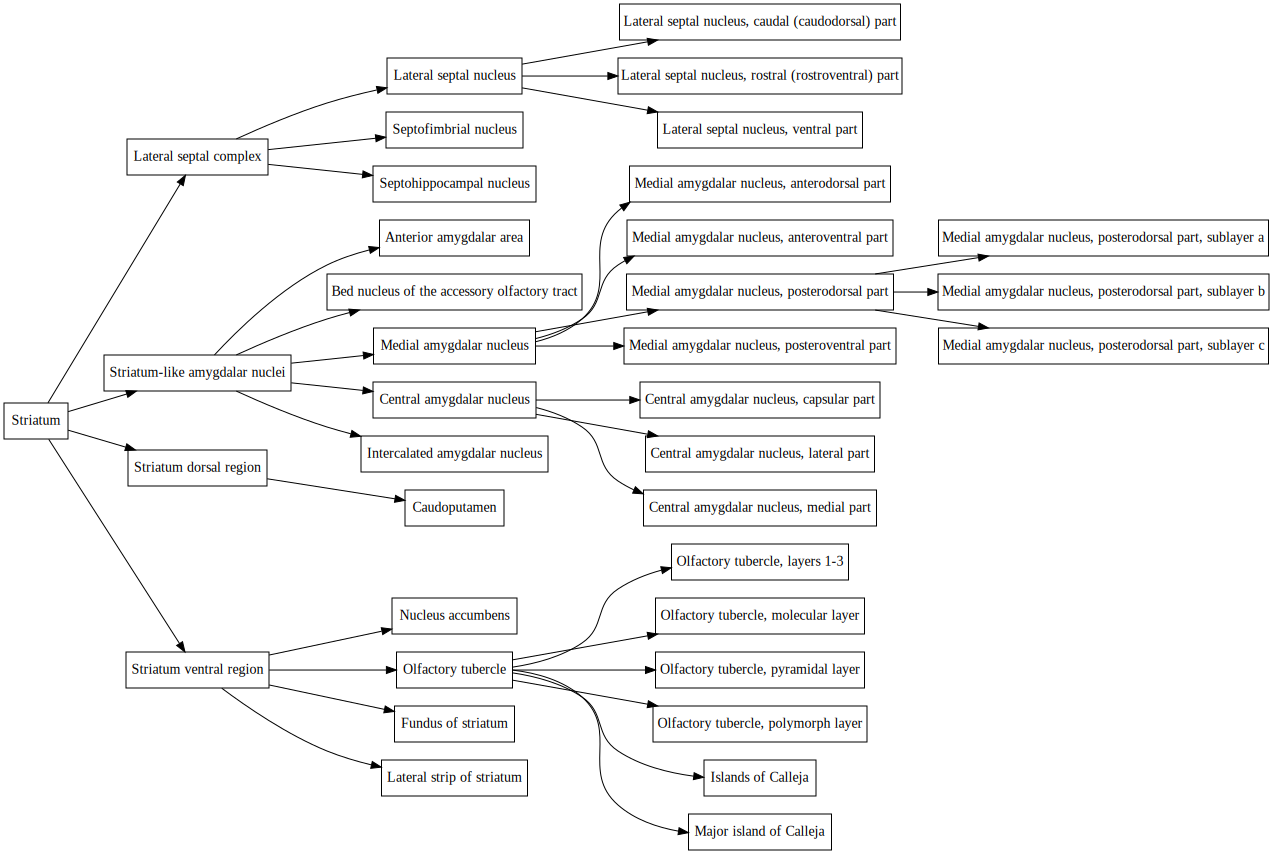

In [40]:
G = graphviz.Digraph()
G.attr('node',shape='box') # default node shape is oval, but box are more readable
make_name_graph(data,G,starting_nodename='Striatum') 
G.attr(rankdir='LR') # default is to show a vertical graph, but horizontal is more readable
G

In [23]:
# Save the graph file so it can be converted to PNG or PDF
G.save('PMA_striatum.dot')

'PMA_striatum.dot'

In [44]:
# Make collapsed graph representing what happens when key is pressed to contract atlas 
def add_nodes_stopper(dic,graph,stopping_nodename=None):
    """
    ---PURPOSE---
    Recursively add nodes to a graph from a dictionary
    representing a brain ontology, but stop adding to that branch
    when you get to a certain node
    ---INPUT---
    dic     dictionary representing an ontology JSON graph
    graph   the graphviz digraph object
    """
    name = dic.get('name')
    
    acronym = dic.get('acronym')
    children = dic.get('children')
    orig_id = dic.get('id')
    new_id = dic.get('graph_order') + 1
    graph.node(name)
    if name == stopping_nodename:
        graph.node(name,style='filled',fillcolor='yellow')
        return
    for child in children:
        child_name = child.get('name')
        graph.edge(name,child_name)
        add_nodes_stopper(child,graph,stopping_nodename=stopping_nodename)
    return 

def make_name_graph_stopper(dic,graph=None,starting_nodename=None,stopping_nodename=None):
    """ 
    ---PURPOSE---
    Make a subgraph of the brain ontology, 
    starting from a provided brain region 
    Will only make the graph of that region and its descendents.
    ---INPUT---
    dic                            dictionary representing an ontology JSON graph
    graph                          the graphviz digraph object
    starting_nodename              the name of the brain region whose subgraph you want to make
    """
    name = dic.get('name')
    acronym = dic.get('acronym')
    children = dic.get('children')
    orig_id = dic.get('id')
    new_id = dic.get('graph_order') + 1
    if name == starting_nodename:
        add_nodes_stopper(dic,graph,stopping_nodename=stopping_nodename)
        return graph
    for child in children:
        child_name = child.get('name')
        make_name_graph_stopper(child,graph,starting_nodename=starting_nodename,stopping_nodename=stopping_nodename)
    return

In [48]:
G = graphviz.Digraph()
G.attr('node',shape='box') # default node shape is oval, but box are more readable
make_name_graph_stopper(data,G,starting_nodename='Striatum',stopping_nodename='Central amygdalar nucleus, capsular part') 
G.attr(rankdir='LR') # default is to show a vertical graph, but horizontal is more readable
G.save('PMA_striatum_collapse1.dot')

'PMA_striatum_collapse1.dot'

In [50]:
G = graphviz.Digraph()
G.attr('node',shape='box') # default node shape is oval, but box are more readable
make_name_graph_stopper(data,G,starting_nodename='Striatum',stopping_nodename='Central amygdalar nucleus') 
G.attr(rankdir='LR') # default is to show a vertical graph, but horizontal is more readable
G.save('PMA_striatum_collapse2.dot')

'PMA_striatum_collapse2.dot'

In [53]:
G = graphviz.Digraph()
G.attr('node',shape='box') # default node shape is oval, but box are more readable
make_name_graph_stopper(data,G,starting_nodename='Striatum',stopping_nodename='Striatum-like amygdalar nuclei') 
G.attr(rankdir='LR') # default is to show a vertical graph, but horizontal is more readable
G.save('PMA_striatum_collapse3.dot')

'PMA_striatum_collapse3.dot'

In [55]:
G = graphviz.Digraph()
G.attr('node',shape='box') # default node shape is oval, but box are more readable
make_name_graph_stopper(data,G,starting_nodename='Striatum',stopping_nodename='Striatum') 
G.attr(rankdir='LR') # default is to show a vertical graph, but horizontal is more readable
G.save('PMA_striatum_collapse4.dot')

'PMA_striatum_collapse4.dot'